<a href="https://colab.research.google.com/github/Angela-Park-JE/TIL_ver1/blob/main/240918_1_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# data import and load libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

pd.set_option('display.max.colwidth', 30)
pd.set_option('display.max.row', 100)

In [ ]:
data_path = '/content/drive/MyDrive/OSSCA pytorch/팀프로젝트/data/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
print(train.shape, test.shape)

train['date'] = pd.to_datetime(train['date'])
train.head()

(3000888, 6) (28512, 5)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
stores = pd.read_csv(data_path + 'stores.csv')
transactions = pd.read_csv(data_path + 'transactions.csv')
holidays = pd.read_csv(data_path + 'holidays_events.csv')
oil = pd.read_csv(data_path + 'oil.csv')

transactions['date'] = pd.to_datetime(transactions['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
oil['date'] = pd.to_datetime(oil['date'])

# 목차: Data preparing

## Concatenating data : `stores`, `transactions`

데이터는 행 별로, 특정 날짜, 특정 가게에서, 카테고리별로 sales를 담고있다.  
한 행이 거래하나를 의미하는 것이 아니기 때문에 가게별 판매 데이터 갯수도 균등하고, 반대로 카테고리 별 데이터 개수도 균등한 것이었다.  

#### 피처 셀렉션을 위해 생각한 가설들은 다음과 같다.
1. **[단원I]** `onpromotion`은 의미상 date, store_nbr, family에 의존한다. 그렇다면 sales와 onpromotion의 영향이 많이 있을까?
    - 확인하기 위해서는: sales가 아예 0이고 onpromotion도 0인(**transaction이 결측치인**), 즉 가게를 열지 않은 것으로 추측되는 날에 대해서는 제외하고 상관계수를 체크해보는 것도 좋아보인다. 데이터가 0인 것에 대해서는 date때문일 뿐인데도 둘 다 0일 때가 많아지면서 데이터를 sparce하게 만드는 경향이 있기 때문이다.
    - 다만, 이 데이터는 날짜x가게x카테고리 별로 데이터가 있는 것이기 때문에 정답이 0일 경우를 감안하여 실제로 훈련할 경우 **아예 쉬는 날에 대해서는 따로 구분할 수 있는 피처**(예시: holiday 데이터)가 꼭 필요할 것으로 보인다.
    - 추가적으로, holiday에서 sales에 대해 추리지 말고, **모든 sales가 0인 holiday를 역추적하여** 해당 holiday는 원래 sales가 0일 수 밖에 없는 것으로, 즉 꼭 쉬게 되는 공휴일 타입을 별도로 정하여 피처를 구성할 수도 있을 것 같다.  

2. **[단원III]** cluster와 type은 store_nbr에 의존한다. 그렇다면 store_nbr에 따라서 취급하지 않는 family가 있을 수 있고 이것이 cluster와 type을 결정하진 않을까?
    - 확인하기 위해서는: store_nbr, type, cluster를 family와 연관지어 확인해보는 방법이 있다.  

3. datetime 자체로는 index에 불과하다. date는 holiday를 활용하여 다음과 같은 처리가 가능할 수 있다.
- day
    - 당일에 holiday 여부를 피처로 넣어 확인하거나
    - 해당일 전후로 축제 기간에 포함되는지 피처로 넣어 확인하거나
    - (특정 가게가 특정 날짜에 연마다 특이사항이 발견된다면 그 부분의 처리는 어떻게 해야할까?)
- month
    - ~month를 season이라는 피처로 이용하거나:~ 이 데이터에 적합하지 않음
- year
    - ~해당 연도에 있을 수 있는 event를 추가적인 정보로 붙이거나:~ 주어진 데이터로만 참여하도록 competition에 제약이 있다면 무용하므로 사용하지 않도록 한다.



#### 주의할 점
1. 확인한 결과로 day에 holiday가 필요하게 된다면 test 데이터에도 똑같은 처리가 필요함을 주의할 것. (데이터가 주어진 사실 자체가 이용을 권장하는 것이므로 최대한 활용하는 것이 좋아보인다.)

2. 시계열 데이터이기 때문에 random sampling으로 시험적 학습이나 테스트가 무용함을 주의할 것.
대신 시차 피처 생성을 하여 만들어 쓸 수 있으며 시계열 데이터에 꽤 유용하다고 한다. 현 시점 기준 과거 시점의 데이터를 추가하는 개념이다.



#### 논의할 점
**[단원II]** 팀 분석 결과 sales에서 일부 이상치가 발견되었다. 데이터를 제대로 이해한 결과, 해당 데이터포인트를 제거하게 되면 해당 날짜, 해당 가게, 해당 카테고리의 sales가 아예 사라지게 되는 것이므로 데이터의 일관성이 무너지게 된다. 그러한 데이터에 대해서는 해당 카테고리에서의 4분위수로 대체하는 것도 좋은 방법이 되지 않을까 생각했다.



### data setting: train+stores+transactions `total_df`

In [ ]:
total_df = train.copy()
total_df = pd.merge(total_df, stores, how = 'left', on = 'store_nbr')
total_df = pd.merge(total_df, transactions, how = 'left', on = ['date', 'store_nbr'])

## I. Onpromotion VS sales : `df_1`

### i. data cleansing


In [ ]:
# get sum
df_offday = total_df.groupby(['date', 'store_nbr'])['sales'].sum()
df_offday = df_offday.reset_index()

# so we can find off-day by stores
df_openday = df_offday[df_offday['sales'] != 0]

# and the data which `date` and `store_nbr` are in df_offday
df_openday = df_openday.rename(columns = {'sales':'total_sales'})
df_1 = pd.merge(total_df, df_openday, how = 'inner', on = ['date', 'store_nbr'])
df_1
# so some data is deleted (result : 2758998 rows × 12 columns)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,total_sales
0,561,2013-01-01,25,AUTOMOTIVE,0.000,0,Salinas,Santa Elena,D,1,770.0,2511.618999
1,562,2013-01-01,25,BABY CARE,0.000,0,Salinas,Santa Elena,D,1,770.0,2511.618999
2,563,2013-01-01,25,BEAUTY,2.000,0,Salinas,Santa Elena,D,1,770.0,2511.618999
3,564,2013-01-01,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,1,770.0,2511.618999
4,565,2013-01-01,25,BOOKS,0.000,0,Salinas,Santa Elena,D,1,770.0,2511.618999
...,...,...,...,...,...,...,...,...,...,...,...,...
2758993,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155.0,18636.477000
2758994,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155.0,18636.477000
2758995,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155.0,18636.477000
2758996,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155.0,18636.477000


### ii. get correlation

In [ ]:
df_1[['sales', 'onpromotion', 'transactions', 'total_sales']].corr(numeric_only = True)

,sales,onpromotion,transactions,total_sales
sales,1.000000,0.424668,0.214815,0.256631
onpromotion,0.424668,1.000000,0.025511,0.088923
transactions,0.214815,0.025511,1.000000,0.837384
total_sales,0.256631,0.088923,0.837384,1.000000


<Axes: >

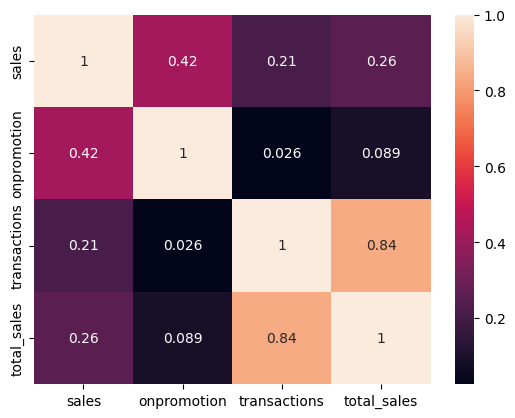

In [ ]:
sns.heatmap(df_1[['sales', 'onpromotion', 'transactions', 'total_sales']].corr(numeric_only = True)
    , annot = True)

### iii. result

(sales와 total_sales는 서로 의미를 같이 하므로 해석에서 제외, transaction은 거래 횟수와 같기 때문에 마찬가지로 맥락을 함께하므로 해석에서 제외. transactions은 당연하게 total_sales와 상관이 높다.)

- sales와 onpromotion은 0.42로 꽤 높은 상관관계를 보이고 있다.  
- onpromotion은 특정 family와 관련이 높기 때문에 transactions나 total_sales와 큰 관계가 있어보이지 않는다.  

> 그렇다면 onpromotion은 꼭 살려두어야 하는 피처이다.

### iv. additional question

- **transaction과 sales의 Equal-variance test** :
    sales가 높을 수록 transaction이 높을 수 있는 것은 정황상 가능하지만, 적은 손님이 고가의 제품을 구매한 날짜의 경우가 있을 수 있다. 반대로 많은 손님이 있었던 날 저가의 제품이 많이 팔렸을 가능성도 있다. transactions, sales는 등분산을 띄고있다고 할 수 있나? 등분산을 띄고있다면 transaction 컬럼을 제외할 수 있을까?
이 문제를 해결하면서 이상치를 어떻게 해결하면 좋을지 만져보았다. (이어서)


## II. sales의 이상치 처리 고민...
+  sales와 transactions 관계


In [ ]:
# co-variance(corr를 이미 구했으니 의미x)
df_1[['sales', 'onpromotion', 'transactions', 'total_sales']].cov()

,sales,onpromotion,transactions,total_sales
sales,1.308663e+06,6178.441747,2.364821e+05,2.844207e+06
onpromotion,6.178442e+03,161.744778,3.127023e+02,1.095643e+04
transactions,2.364821e+05,312.702319,9.279104e+05,7.803911e+06
total_sales,2.844207e+06,10956.425339,7.803911e+06,9.385882e+07


<ipython-input-9-0b6117586a37>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_1['sales'], kde=False, fit=scipy.stats.norm, label = f"sales (분산 :{np.round(df_1['sales'].std(),2)})")
<ipython-input-9-0b6117586a37>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df_1['transactions']

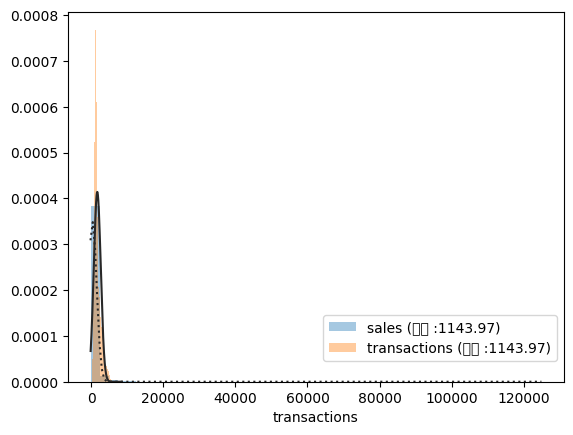

In [ ]:
# visualization : 정규분포의 확률밀도함수 표시
ax = sns.distplot(df_1['sales'], kde=False, fit=scipy.stats.norm, label = f"sales (분산 :{np.round(df_1['sales'].std(),2)})")
ax = sns.distplot(df_1['transactions'], kde=False, fit=scipy.stats.norm, label = f"transactions (분산 :{np.round(df_1['sales'].std(),2)})")
ax.lines[0].set_linestyle(":")
plt.legend(bbox_to_anchor=(1.0, .2))
plt.show()

<Axes: ylabel='sales'>

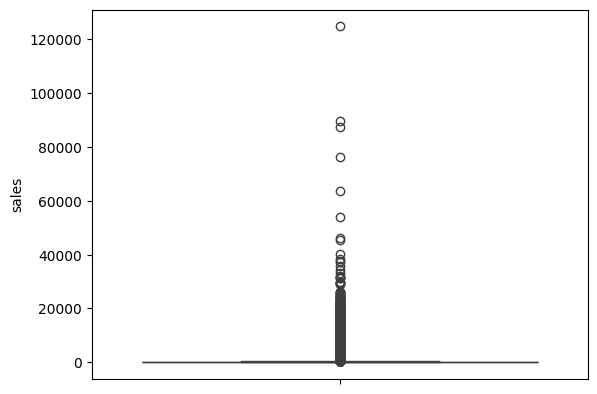

In [ ]:
# sales : boxplot
sns.boxplot(df_1['sales'])

### i. Handling sales outliers with IQR

IQR을 활용하여 sales의 이상치 문제를 해결해보자


시행착오: 다음은 sales자체만 가지고 iqr을 구하여 적용하였을 때이다.  
401610 rows × 12 columns, 40만 건 이상이 이상치로 잡힌다.

In [ ]:
# iqr 기준 sales가 이상치에 해당하는 데이터 뜯어 보기
# get values from df_1['sales'].describe()
Q1 = df_1['sales'].describe()['25%']
Q2 = df_1['sales'].describe()['50%']
Q3 = df_1['sales'].describe()['75%']
IQR = Q3 - Q1

# outliers by descending order, cut by 300
df_1_salesout = df_1[df_1['sales']> Q3+IQR*1.5]

# 가게별 sales 이상치 갯수
df_1[df_1['sales']> Q3+IQR*1.5].sort_values(['sales'], ascending = False)[:1000].groupby(['store_nbr']).count()['sales']

,sales
store_nbr,
2,5
3,32
9,11
11,7
20,7
24,3
26,3
28,1
31,3


이상치가 특별히 많은 가게들이 있기도 하다. 그런것을 감안하면 44, 45, 46, 47의 경우 다른 클러스터나 타입인걸까?


In [ ]:
pd.merge(df_1_salesout.groupby(['store_nbr']).count()['sales'].reset_index(), stores, how = 'left').set_index('store_nbr')

,sales,city,state,type,cluster
store_nbr,,,,,
1,6823,Quito,Pichincha,D,13
2,9097,Quito,Pichincha,D,13
3,14008,Quito,Pichincha,D,8
4,7973,Quito,Pichincha,D,9
5,6636,Santo Domingo,Santo Domingo de los Tsach...,D,4
6,9767,Quito,Pichincha,D,13
7,10263,Quito,Pichincha,D,8
8,10527,Quito,Pichincha,D,8
9,9715,Quito,Pichincha,B,6


이상치가 type이 A에 유독 높은 값이 몰려있는 것이 재미있다.

 IQR의 기준을 sales만이 아니라 family 별 sales 기준으로 나뉘어지도록 해보았다.

In [ ]:
# frame
df_1_out = df_1[:1]

# get IQR by family and concat the data
for i in list(df_1['family'].unique()):
    fam = df_1[df_1['family'] == i]['sales']
    Q1 = fam.describe()['25%']
    Q2 = fam.describe()['50%']
    Q3 = fam.describe()['75%']
    IQR = Q3 - Q1

    df_1_out = pd.concat([df_1_out, df_1[(df_1['family'] == i)&(df_1['sales']> Q3+IQR*1.5)]], axis = 0)

In [ ]:
# finally we can meet the outliers
df_1_out = df_1_out[1:]
df_1_out

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,total_sales
3036,5313,2013-01-03,9,AUTOMOTIVE,22.000000,0,Quito,Pichincha,B,6,2396.0,10431.719000
5643,8382,2013-01-05,44,AUTOMOTIVE,26.000000,0,Quito,Pichincha,A,5,4921.0,31382.508000
5676,8415,2013-01-05,45,AUTOMOTIVE,37.000000,0,Quito,Pichincha,A,11,4331.0,27104.223034
5874,8613,2013-01-05,50,AUTOMOTIVE,23.000000,0,Ambato,Tungurahua,A,14,3459.0,17930.364000
6072,8877,2013-01-05,9,AUTOMOTIVE,27.000000,0,Quito,Pichincha,B,6,2604.0,13057.110000
...,...,...,...,...,...,...,...,...,...,...,...,...
2756720,2998610,2017-08-14,44,SEAFOOD,81.965004,0,Quito,Pichincha,A,5,4039.0,35617.528004
2756753,2998643,2017-08-14,45,SEAFOOD,79.414000,0,Quito,Pichincha,A,11,3743.0,35065.714000
2756885,2998775,2017-08-14,49,SEAFOOD,79.832000,0,Quito,Pichincha,A,11,2916.0,31229.006000
2758502,3000392,2017-08-15,44,SEAFOOD,80.240000,0,Quito,Pichincha,A,5,3815.0,33141.322000


181202 rows로 많이 줄어들긴 했지만, 일부 카테고리에 따라서 outlier로 취급하기 어려운 금액도 있을 수 있다.

다음은 의아한 부분이 있는 이상치때문에 찍어본 describe()이다.

In [ ]:
df_1[df_1['family'] == 'AUTOMOTIVE']['sales'].describe()

,sales
count,83606.000000
mean,6.636151
std,6.176438
min,0.000000
25%,3.000000
50%,5.000000
75%,9.000000
max,255.000000


따라서 outlier를 정하는 기준을 (1) 전체 sales로 정할 수도 있고, (2) '카테고리별'로 상한선을 둘 수도 있다.
또한 두 가지를 한꺼번에 적용하여 (3) 전체 세일즈에서의 outlier 즉 `df_1[df_1['sales']> Q3+IQR*1.5]`의 기준에도 맞는다면 outlier로 취급할 수도 있다.
'

이게 아닌데... 결론을 못냈습니다 죄송해요 TT 3 TT


## III. store_nbr과 cluster, type

cluster와 type은 store_nbr에 의존한다. 그렇다면 store_nbr에 따라서 취급하지 않는 family가 있을 수 있고 이것이 cluster와 type을 결정하진 않을까?  


### i. type별 sales, transactions

In [ ]:
total_df

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155.0


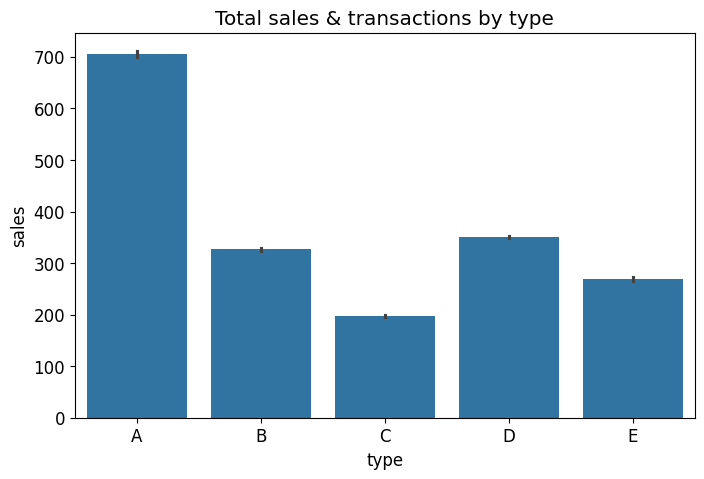

In [ ]:
# 부끄러운 나의 코드 (실행세 55초가 걸린다.)
# by stores
plt.rc('font', size = 12)
figure, ax = plt.subplots()
figure.set_size_inches(8, 5)

# sum of sales by types
group_type = total_df.groupby('type').agg({'sales':'sum'})
group_type = group_type.reset_index()

sns.barplot(x = 'type', y = 'sales', data = total_df, order = sorted(list(total_df['type'].unique())) )

ax.set(title = 'Total sales & transactions by type')
plt.show()

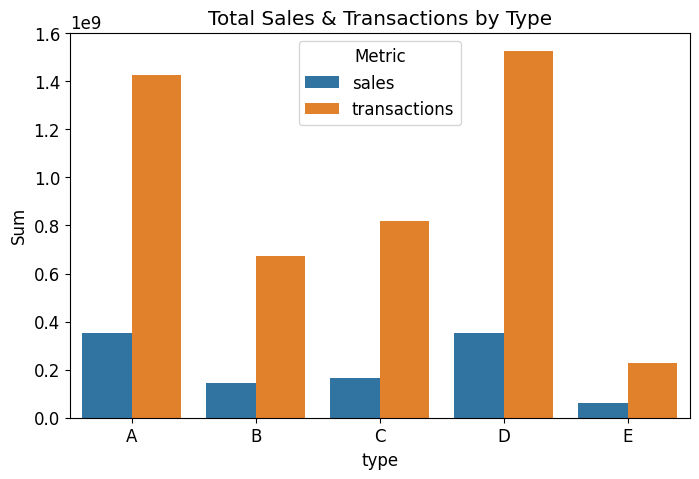

In [ ]:
# 데이터프레임 그룹화 및 sales와 transactions의 합계 계산
group_type = total_df.groupby('type').agg({'sales': 'sum', 'transactions': 'sum'}).reset_index()

# 데이터를 melt하여 'sales'와 'transactions'을 하나의 컬럼으로 합침
group_type_melted = pd.melt(group_type, id_vars='type', value_vars=['sales', 'transactions'],
                            var_name='Metric', value_name='Value')

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x='type', y='Value', hue='Metric', data=group_type_melted)

plt.title('Total Sales & Transactions by Type')
plt.ylabel('Sum')
plt.show()

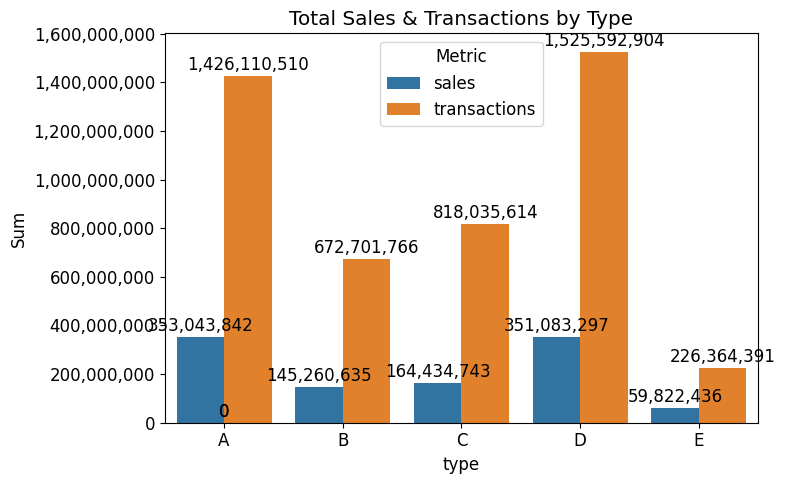

In [ ]:
# 데이터프레임 그룹화 및 sales와 transactions의 합계 계산
group_type = total_df.groupby('type').agg({'sales': 'sum', 'transactions': 'sum'}).reset_index()

# 데이터를 melt하여 'sales'와 'transactions'을 하나의 컬럼으로 합침
group_type_melted = pd.melt(group_type, id_vars='type', value_vars=['sales', 'transactions'],
                            var_name='Metric', value_name='Value')

# 시각화
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='type', y='Value', hue='Metric', data=group_type_melted)

# 각 막대 위에 값 추가
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 8),
                textcoords='offset points')

# y축 값을 정수형태로 표시
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.title('Total Sales & Transactions by Type')
plt.ylabel('Sum')
plt.tight_layout()
plt.show()

### ii.cluster별 sales, transactions


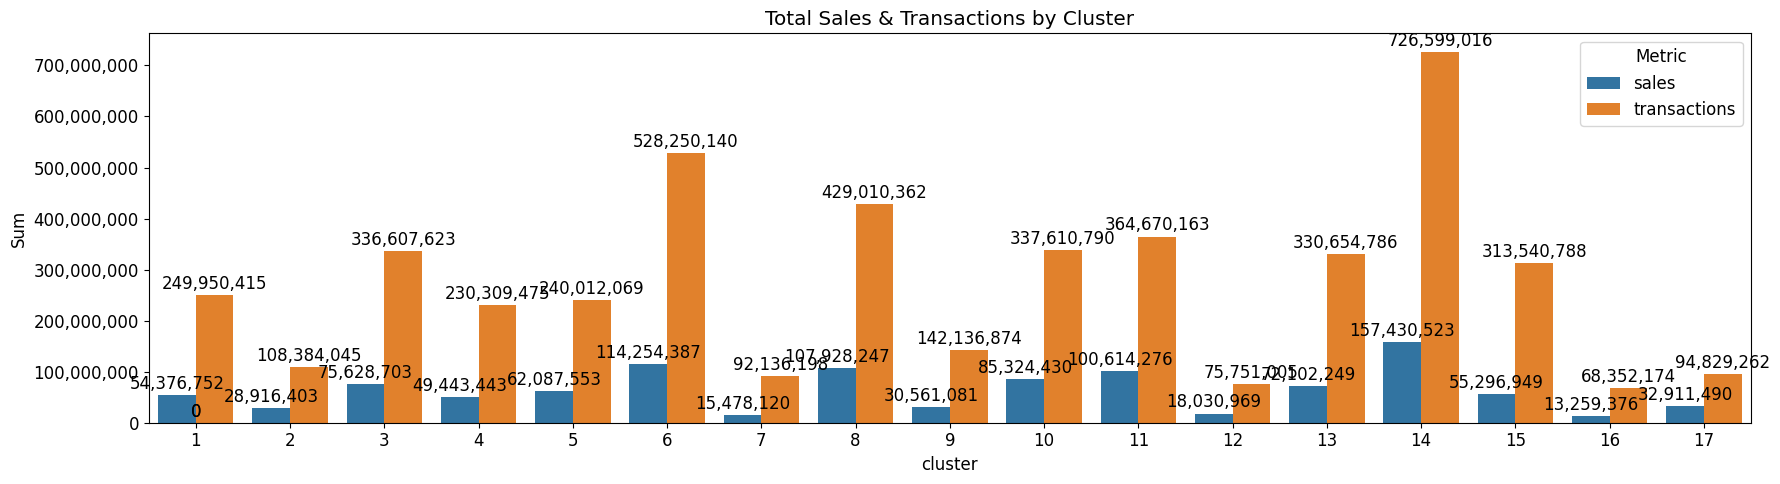

In [ ]:
# 데이터프레임 그룹화 및 sales와 transactions의 합계 계산
group_cluster = total_df.groupby('cluster').agg({'sales': 'sum', 'transactions': 'sum'}).reset_index()

# 데이터를 melt하여 'sales'와 'transactions'을 하나의 컬럼으로 합침
group_cluster_melted = pd.melt(group_cluster, id_vars='cluster', value_vars=['sales', 'transactions'],
                            var_name='Metric', value_name='Value')

# 시각화
plt.figure(figsize=(18, 5))
ax = sns.barplot(x='cluster', y='Value', hue='Metric', data=group_cluster_melted)

# 각 막대 위에 값 추가
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 8),
                textcoords='offset points')

# y축 값을 정수형태로 표시
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.title('Total Sales & Transactions by Cluster')
plt.ylabel('Sum')
plt.tight_layout()
plt.show()

### iii. family와 type/cluster의 관계

In [ ]:
# type과 family의 관계: type이 취급물품과 관련이 있을까?
# type별로 family의 sales를 보고자 한다.

# sum이 0인 곳이 있을까?
group_tyfa = total_df.groupby(['type', 'family'])[['sales', 'onpromotion']].sum().reset_index()
group_tyfa[group_tyfa['sales'] == 0]

,type,family,sales,onpromotion
1,A,BABY CARE,0.0,0
37,B,BOOKS,0.0,0
70,C,BOOKS,0.0,0
136,E,BOOKS,0.0,0



#### result : type별 family
onpromotion도, sales도 0이라면 판매중이 아닐 가능성이 높다.  

그렇다면,  
- A type의 store에서는 baby care를 팔지 않는 것으로 추정된다.  
- B, C, E type의 store에서는 books를 팔지 않는 것으로 추정된다.  
- 반대로 D type의 store에서는 모든 종류의 family를 파는 것으로 추정된다.  


In [ ]:
# cluster와 family의 관계: cluster이 취급물품과 관련이 있을까?
# cluster별로 family의 sales를 보고자 한다.

# sum이 0인 곳이 있을까?
group_clfa = total_df.groupby(['cluster', 'family'])[['sales', 'onpromotion']].sum().reset_index()
group_clfa[group_clfa['sales'] == 0]

,cluster,family,sales,onpromotion
70,3,BOOKS,0.0,0
133,5,BABY CARE,0.0,0
169,6,BOOKS,0.0,0
202,7,BOOKS,0.0,0
331,11,BABY CARE,0.0,0
367,12,BOOKS,0.0,0
430,14,BABY CARE,0.0,0
466,15,BOOKS,0.0,0
499,16,BOOKS,0.0,0
529,17,BABY CARE,0.0,0



#### result : cluster별 family
마찬가지로, onpromotion도, sales도 0이라면 판매중이 아닐 가능성이 높다.  

그렇다면,  
- 5, 11, 14, 17 cluster의 store에서는 baby care를 팔지 않는 것으로 추정된다.  
- 3, 6, 7, 12, 15, 16 cluster의 store에서는 books를 팔지 않는 것으로 추정된다.  
- 그 외 cluster의 store에서는 모든 종류의 family를 파는 것으로 추정된다.  


#### 의문: 그렇다면 family 기반으로 type과 cluster의 관계는?


In [ ]:
# 특정 family를 안 파는 것이 type과 cluster와 비슷한 양상을 보이고 있다. 책을 팔지 않거나, 아기용품을 팔지 않거나.

# 특정 family를 안 파는 cluster에 대하여 store들 정보를 붙인다.
special_stores = pd.merge(group_clfa[group_clfa['sales'] == 0][['cluster', 'family']], stores, how = 'outer', on = 'cluster')
nonspecial_stores = special_stores[special_stores['family'].isna()]

# cluster별로 특정 family를 안파는 클러스터에 해당하는 가게들의 정보
special_stores = special_stores[~special_stores['family'].isna()]
# cluster별로 모든 family를 취급하는 클러스터에 해당하는 가게들의 정보
special_stores.sort_values('type')

,cluster,family,store_nbr,city,state,type
30,17,BABY CARE,51,Guayaquil,Guayas,A
18,11,BABY CARE,52,Manta,Manabi,A
17,11,BABY CARE,49,Quito,Pichincha,A
16,11,BABY CARE,45,Quito,Pichincha,A
22,14,BABY CARE,48,Quito,Pichincha,A
21,14,BABY CARE,47,Quito,Pichincha,A
7,5,BABY CARE,44,Quito,Pichincha,A
20,14,BABY CARE,46,Quito,Pichincha,A
23,14,BABY CARE,50,Ambato,Tungurahua,A
8,6,BOOKS,9,Quito,Pichincha,B


In [ ]:
nonspecial_stores.sort_values('type')

,cluster,family,store_nbr,city,state,type
49,10,NaN,31,Babahoyo,Los Rios,B
31,13,NaN,1,Quito,Pichincha,D
46,10,NaN,26,Guayaquil,Guayas,D
45,1,NaN,27,Daule,Guayas,D
44,1,NaN,25,Salinas,Santa Elena,D
43,1,NaN,24,Guayaquil,Guayas,D
52,2,NaN,37,Cuenca,Azuay,D
41,4,NaN,38,Loja,Loja,D
40,4,NaN,5,Santo Domingo,Santo Domingo de los Tsach...,D
42,4,NaN,41,Machala,El Oro,D


여기서 알 수 있는 것:  
- [단원I]에서 보았던 극단적 이상치가 존재한 44, 45, 46, 47 가게들은 BABY CARE를 팔지 않는 매장이다. 이들은 46, 47은 클러스터가 같고 나머지와는 클러스터가 다 다르지만 타입이 같고 똑같이 키토에 있는 매장이다.  
- `[49	10	NaN	31	Babahoyo	Los Rios	B]`라는 데이터 포인트를 보고, "`Babahoyo`" 지역에 있는 유일한 매장으로, type B 유일하게 모든 family를 파는 매장이다.



#### 의문: E type의 매장에서는 BOOKS를 팔지 않는 것으로 나타났었는데, 왜 이 결과에서는 E 매장이 걸러지지 않았을까?


그렇다면 type별 family에서의 걸러진 type에 대해서 둘로 나누어 피처를 생성하고, 마찬가지로 cluster에 대해서도 같은 작업을 해보자.



In [ ]:
# type별로 무언가를 안파는 type
group_tyfa[group_tyfa['sales'] == 0][['type', 'family']]

# cluster별로 무언가를 안파는 가게들
group_clfa[group_clfa['sales'] == 0][['cluster', 'family']]

# 각각의 데이터를 stores 데이터에 붙여서 특정 가게에서 무엇을 안파는지 알아보기
tmp = pd.merge(stores, group_tyfa[group_tyfa['sales'] == 0][['type', 'family']], how = 'left', on = 'type')
tmp = pd.merge(tmp, group_clfa[group_clfa['sales'] == 0][['cluster', 'family']], how = 'left', on = 'cluster')

# 이 가게의 오픈 시점을 알 수 있을까 하여 붙이는 데이터
tmp1 = transactions[transactions['transactions'] > 0].groupby('store_nbr')['date'].min().reset_index()
tmp = pd.merge(tmp, tmp1, how = 'left', on = 'store_nbr')

# columns 정리
tmp = tmp.rename(columns = {'family_x':'bytype', 'family_y':'bycluster', 'date':'start_date'})
tmp

,store_nbr,city,state,type,cluster,bytype,bycluster,start_date
0,1,Quito,Pichincha,D,13,NaN,NaN,2013-01-02
1,2,Quito,Pichincha,D,13,NaN,NaN,2013-01-02
2,3,Quito,Pichincha,D,8,NaN,NaN,2013-01-02
3,4,Quito,Pichincha,D,9,NaN,NaN,2013-01-02
4,5,Santo Domingo,Santo Domingo de los Tsach...,D,4,NaN,NaN,2013-01-02
5,6,Quito,Pichincha,D,13,NaN,NaN,2013-01-02
6,7,Quito,Pichincha,D,8,NaN,NaN,2013-01-02
7,8,Quito,Pichincha,D,8,NaN,NaN,2013-01-02
8,9,Quito,Pichincha,B,6,BOOKS,BOOKS,2013-01-02
9,10,Quito,Pichincha,C,15,BOOKS,BOOKS,2013-01-02


In [ ]:
# # start date가 2013년이 아닌 가게들만 추리기
# after13 = tmp[tmp['start_date'].dt.year != 2013]['store_nbr']

# # 13년이 아닌 가게들은 뭔가 다른게 있을까?
# pd.merge(tmp, after13, how = '')



# IV. 회의 후 의문 : onpromotion의 2015-16 사이의 증가세




## i. 가게별 연도별 promotion
(그럼 혹시 15-16년도 기점으로 매장이 늘은건 아닐까? 그 매장들이 특별히 프로모션을 많이 하는 애들이 아닐까? 한번 봐야겠다.)

In [ ]:
# tmp1 : 각 가게의 거래 오픈일자를 담고있다
tmp1.sort_values('date', ascending = False).head(10)

,store_nbr,date
51,52,2017-04-20
21,22,2015-10-09
41,42,2015-08-21
20,21,2015-07-24
28,29,2015-03-20
19,20,2015-02-13
52,53,2014-05-29
35,36,2013-05-09
38,39,2013-01-02
30,31,2013-01-02


In [ ]:
# personal palette
p5 = ['gold', 'deepskyblue', 'darkred', 'violet', 'limegreen']
p3 = [ 'darkred', 'violet', 'limegreen']

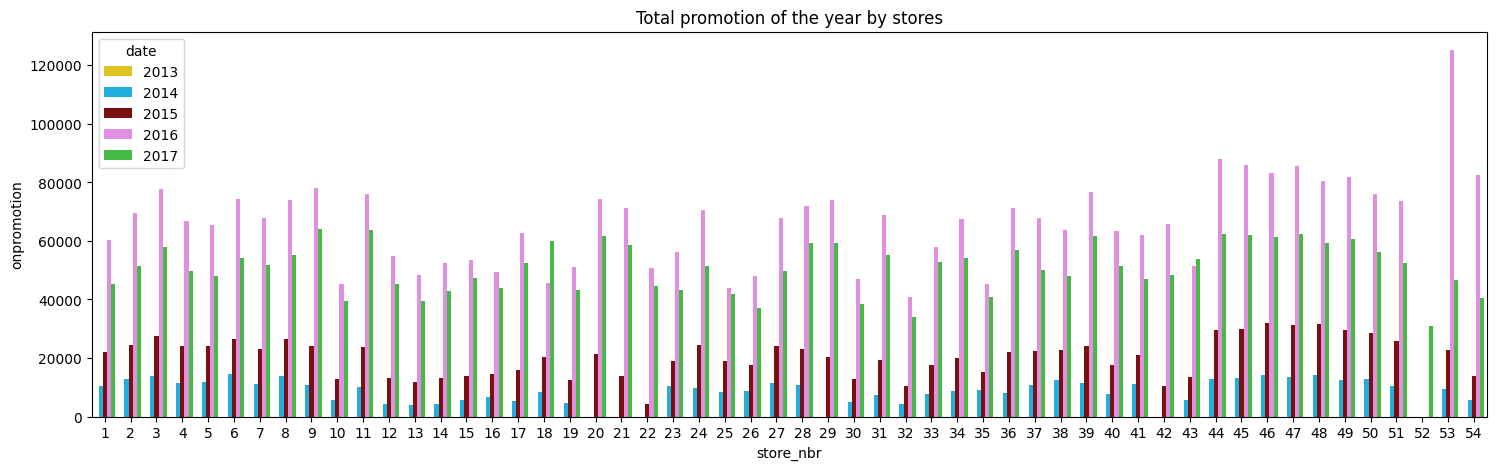

In [ ]:
# 이 데이터에 더해, 가게들의 연도별 총 promotion을 알아보자.
tmp2 = total_df.groupby(['store_nbr', total_df['date'].dt.year])['onpromotion'].sum().reset_index()

plt.rc('font', size = 10)
figure, ax = plt.subplots()
figure.set_size_inches(18, 5)

sns.barplot(data = tmp2, x = 'store_nbr', y = 'onpromotion', hue = 'date', palette = p5)
ax.set(title = 'Total promotion of the year by stores')
plt.show()

한눈에 보려니 다소 보작하긴 하나, 18, 43, 52를 제외하고 모두 2016년에 프로모션을 가장 많이 한 것으로 나타난다.

또한 52번의 경우 2017년 데이터만 존재한다.

그렇다면 2015, 16 데이터만으로는 어떨까?

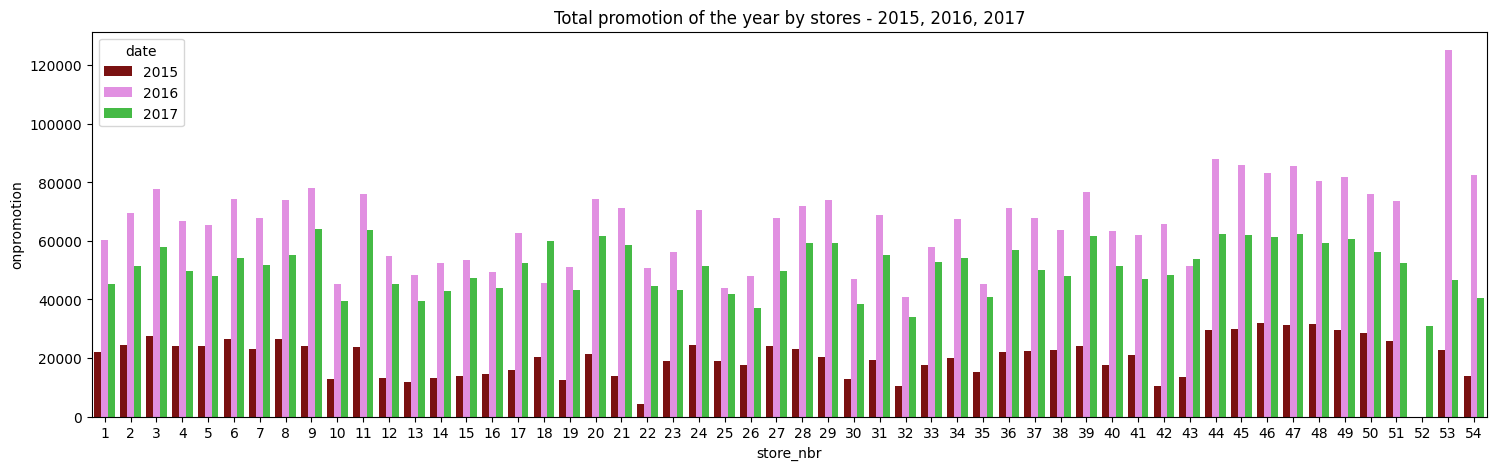

In [ ]:
# 가게들의 연도별 총 promotion을 알아보자.
tmp2 = total_df.groupby(['store_nbr', total_df['date'].dt.year])['onpromotion'].sum().reset_index()
tmp2 = tmp2.query("`date` in [2015, 2016, 2017]")

plt.rc('font', size = 10)
figure, ax = plt.subplots()
figure.set_size_inches(18, 5)

sns.barplot(data = tmp2, x = 'store_nbr', y = 'onpromotion', hue = 'date', palette = p3)
ax.set(title = 'Total promotion of the year by stores - 2015, 2016, 2017')
plt.show()

평균적으로 보는 것도 필요해보인다.


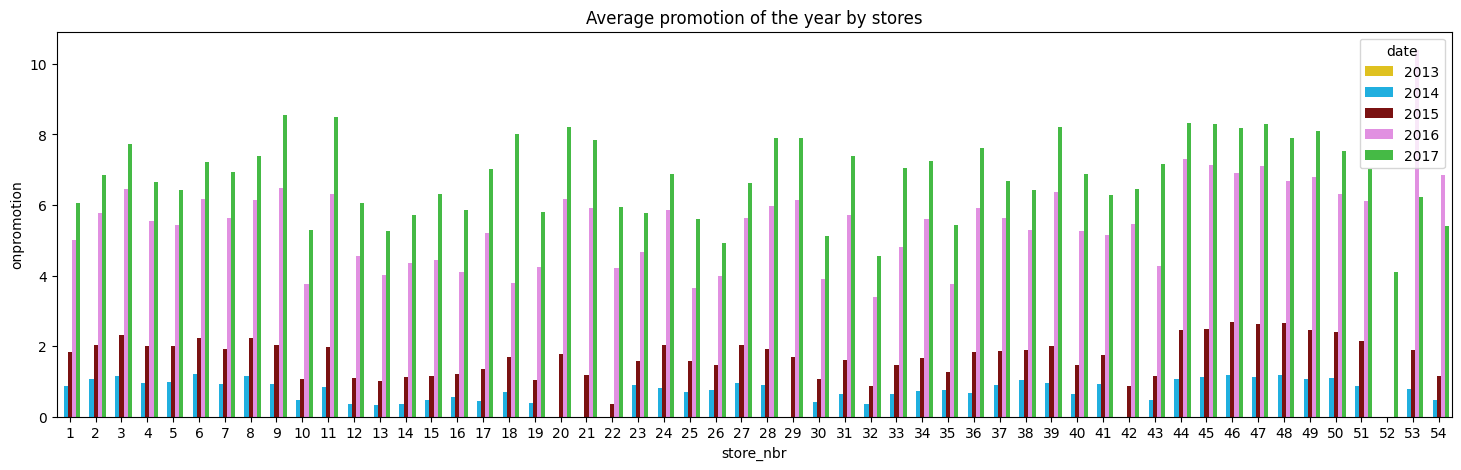

In [ ]:
# 가게들의 연도별 총 promotion을 알아보자.
tmp2 = total_df.groupby(['store_nbr', total_df['date'].dt.year])['onpromotion'].mean().reset_index()

plt.rc('font', size = 10)
figure, ax = plt.subplots()
figure.set_size_inches(18, 5)

sns.barplot(data = tmp2, x = 'store_nbr', y = 'onpromotion', hue = 'date', palette = p5)
ax.set(title = 'Average promotion of the year by stores')
plt.show()

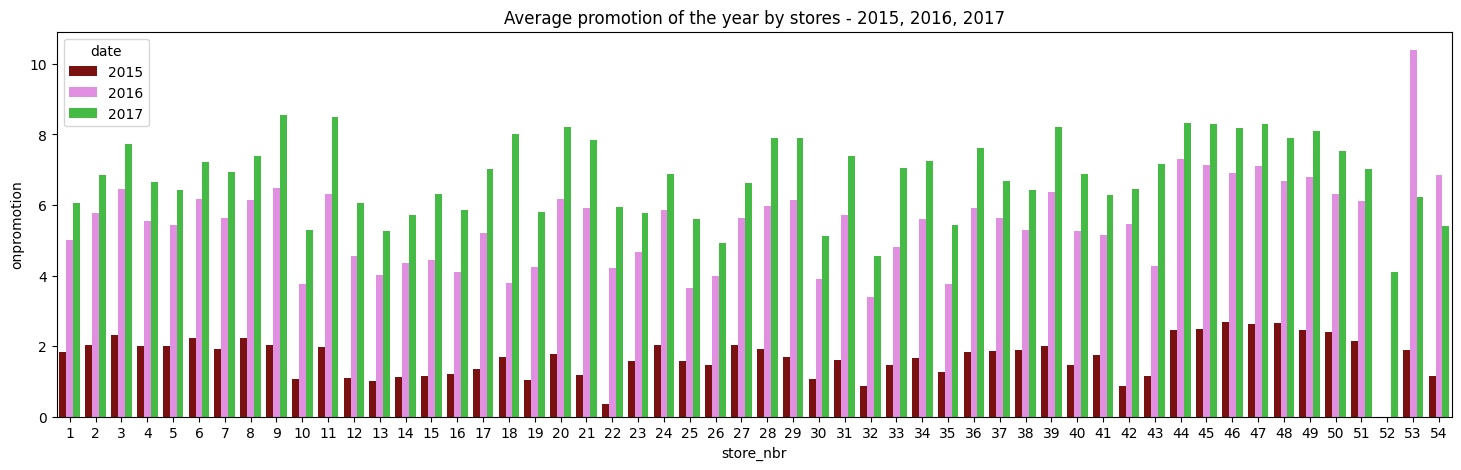

In [ ]:
# 가게들의 연도별 평균 promotion을 알아보자.
tmp2 = total_df.groupby(['store_nbr', total_df['date'].dt.year])['onpromotion'].mean().reset_index()
tmp2 = tmp2.query("`date` in [2015, 2016, 2017]")

plt.rc('font', size = 10)
figure, ax = plt.subplots()
figure.set_size_inches(18, 5)

sns.barplot(data = tmp2, x = 'store_nbr', y = 'onpromotion', hue = 'date', palette = p3)
ax.set(title = 'Average promotion of the year by stores - 2015, 2016, 2017')
plt.show()

### result

- 대부분의 가게에서 2016년도, 2017년도에 확연히 높은 총수의 promotion이 진행된 것으로 보인다. 2015년과는 큰 차이를 보이고 있다. 총합도 2016년이 가장 크다.  
    - 15년과 16년 사이에 특정한 가게가 더 많이 오픈을 했다기 보다는 전사적인 프로모션이 있었던 것으로 보인다. (새로생긴 가게-52 store 제외)
- 그러나 평균으로 보았을 때는 53, 54 store를 제외하고 2016년보다는 2017년도에 더 많이 promotion이 있었다.
    - 2016년도엔 특정 날짜(기간)에 집중적으로 promotion이 있었던 것으로 추정된다.




## ii. 카테고리별 연도별 promotion

카테고리별 연도별 값도 볼까?

유독 프로모션을 많이 하는 카테고리가 있을 수도 있다. 물건의 가짓수가 많은 카테고리가 유독 큰 수를 이끌어낼 수도 있기 때문이다.

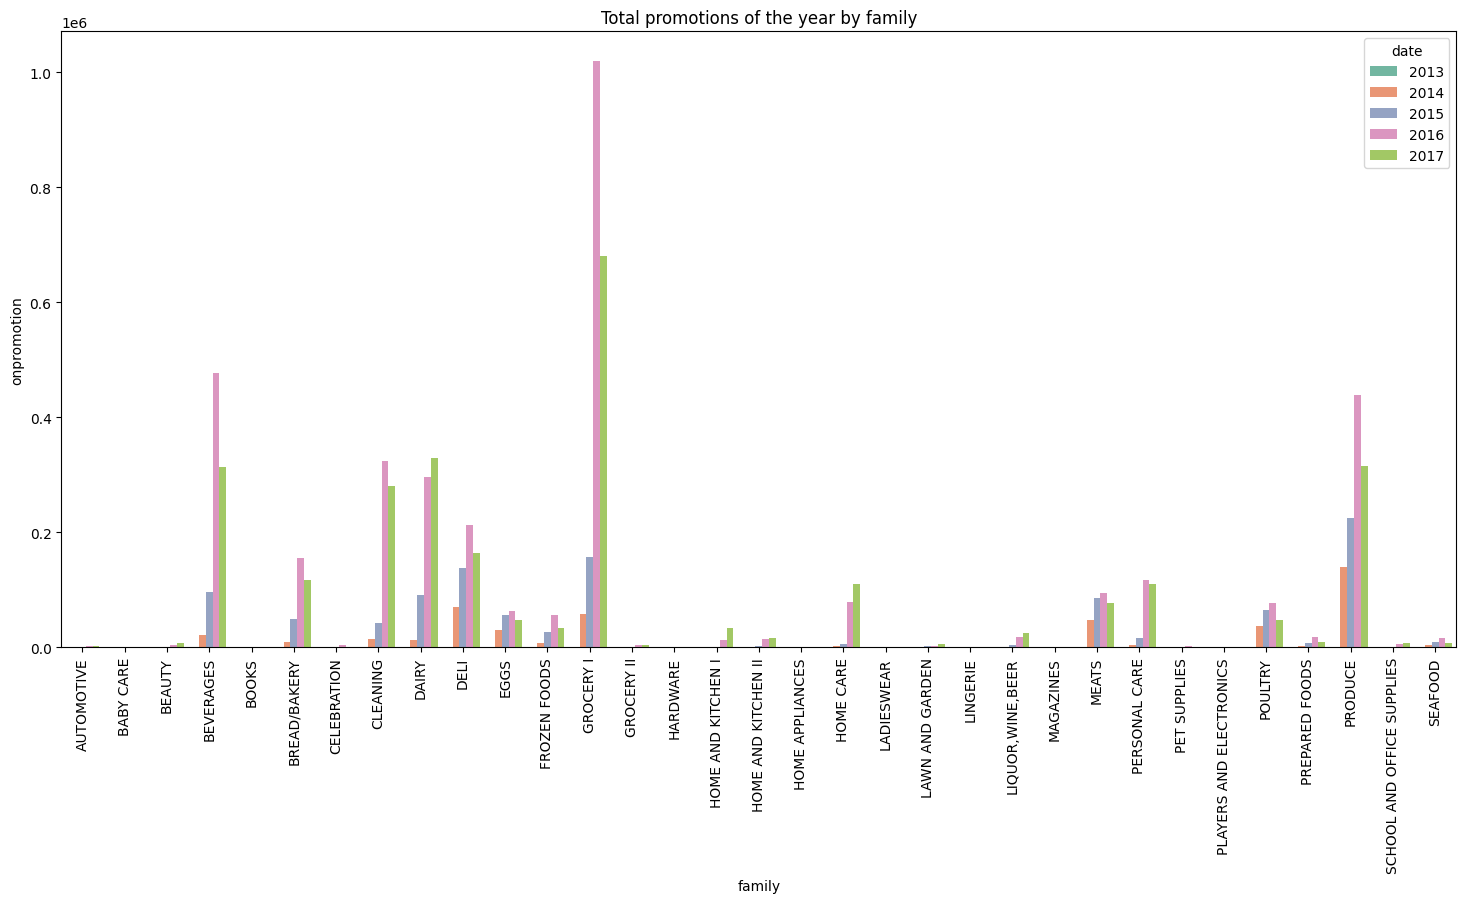

In [ ]:
tmp3 = total_df.groupby(['family', total_df['date'].dt.year])['onpromotion'].sum().reset_index()

plt.rc('font', size = 10)
figure, ax = plt.subplots()
figure.set_size_inches(18, 8)

sns.barplot(data = tmp3, x = 'family', y = 'onpromotion', hue = 'date', palette = 'Set2')
plt.xticks(rotation = 90)
ax.set(title = 'Total promotions of the year by family')
plt.show()

혹시나 했는데 역시나 grocery1이 유독 많은 것을 확인할 수 있다.


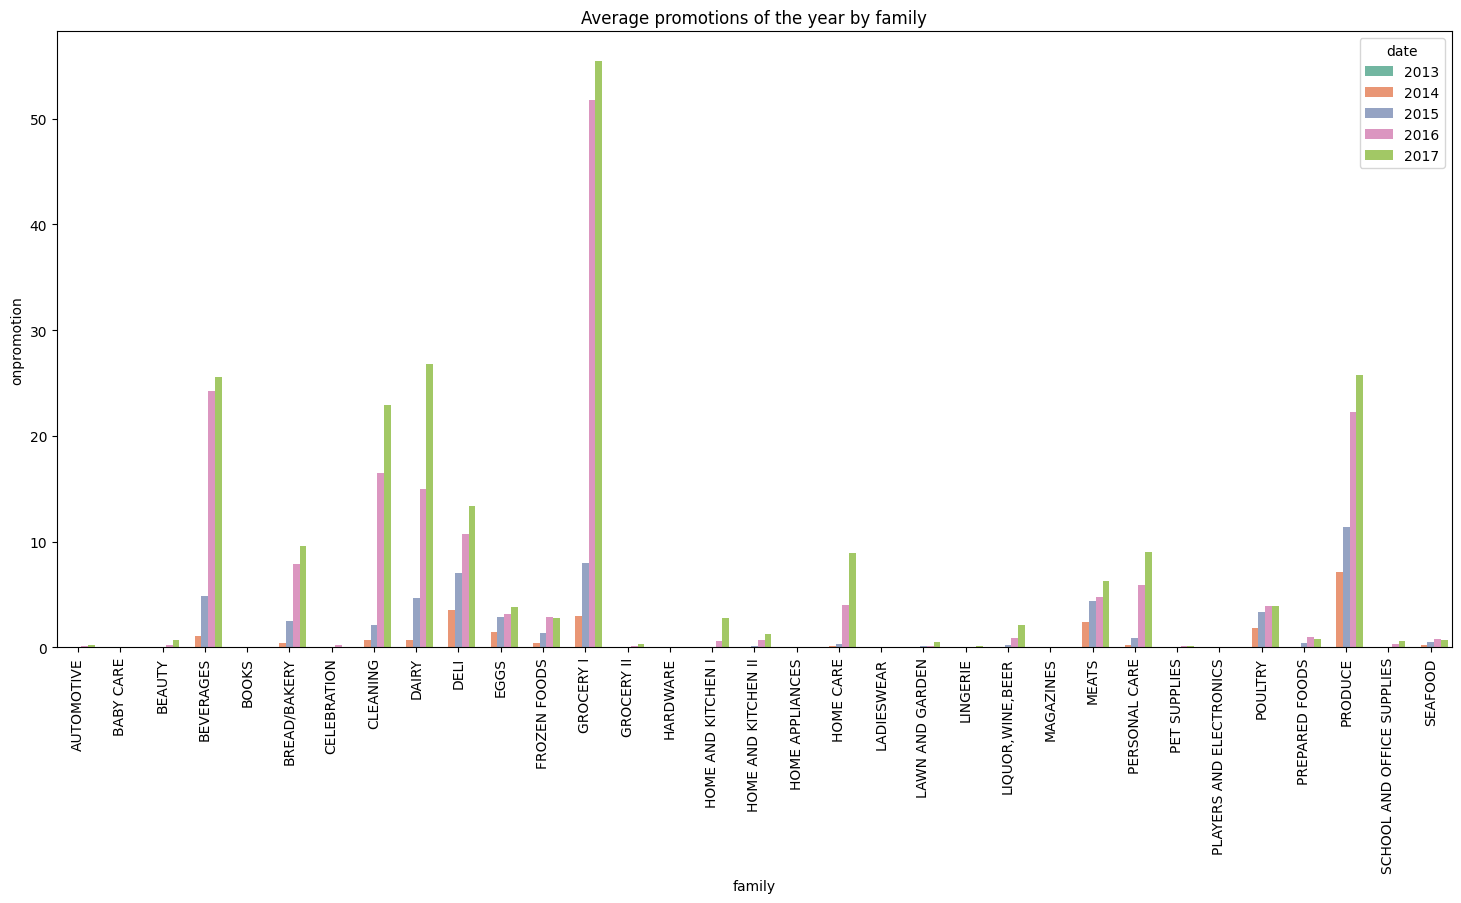

In [ ]:
# 이번엔 평균이다
tmp3 = total_df.groupby(['family', total_df['date'].dt.year])['onpromotion'].mean().reset_index()

plt.rc('font', size = 10)
figure, ax = plt.subplots()
figure.set_size_inches(18, 8)

sns.barplot(data = tmp3, x = 'family', y = 'onpromotion', hue = 'date', palette = 'Set2')
plt.xticks(rotation = 90)
ax.set(title = 'Average promotions of the year by family')
plt.show()

재미있는 결과가 나왔다. 총 onpromotion 수로는 2016년이 압도적으로 많았지만, 평균적으로는 2017년이 많은 것으로 볼 수 있다.

그리고 모든 카테고리에서 그런 것은 아니지만 확실히 2015년보다 2016년에 더 많은 promotion이 진행된 것을 확인할 수 있다.  





### result:

- 2015년도에서 2016년도 사이에 promotion 총합에 큰 증가세가 있다.
    - 가장 큰 차이를 보인 것은 GROCERY I 이다. (이상치가 있었던 카테고리)
- 총 합으로는 확실히 주 카테고리에서 2016년에 더 많이 있었던 것으로 보이지만, 연 평균적으로는 2017년에 좀 더 많은 promotion이 진행된 것으로 보인다.
    - 즉 2016년에는 일부 기간에 큰 행사를 진행했던 것으로 보이고, 2017년에는 판매 촉진을 위한 꾸준한 promotion 구성이 있었던 것으로 보인다.



> 추가적으로
GROCERYI에 대해 좀 더 알아볼 수 있으면 좋겠다.

